# First attempt at actor-critic

My very first attempt at solving the TSP will utilize a deterministic actor-critic model. This is incredibly simplistic and I doubt it will work, but let's just see what happens...

The actor model $\pi$ returns an action $a = \pi(s)$, where $a$ is a vector of real numbers. The sequence of stops on the salesman's circuit is given by the ranking of of these values, i.e. the lowest value is the first stop, second lowest is the next stop, etc. You can get this by doing `argsort(action)`. Unfortunately the sorting operation itself is not differentiable, though you can differentiate through it to change the input values, so this may not work well. The state $s$ simply contains the $(x, y)$ coordinates of the locations, so it is a tensor of shape $(N,2)$, where $N$ is the number of locations.

The architecture of the actor and critic models are simplistic graph convolutional neural networks that take in a node feature matrix $V$ (for the actor $V=s$, for the critic, $V$ is the concatenation of $[s,a]$ along the last dimension), and evolve this by repeatedly applying the following operation:
$$
V_{xbj} \leftarrow \text{relu}\left( \sum_{a,i} A_{ab} V_{xai} W_{ij} + \beta_j \right)
$$
where $A$ is a modified adjacency matrix of the graph, $W$ is a learnable feature matrix, and $\beta$ is a learnable bias vector. Indices $a,b$ index into the nodes of the graph, $i,j$ index into the elements of the feature space, and $x$ indexes into the batch dimension.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/ecotner/neural_tsp/notebooks/training

/home/ecotner/neural_tsp/notebooks/training


In [3]:
import time
import random

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

from neuraltsp.environments import FixedTSPEnv
from neuraltsp.models.actor_critic_01 import Actor, Critic

In [4]:
# initialize GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


The environment is also incredibly simple. Each episode is only a single step (so this is more of a bandit problem), so the reward is simply the negative of the distance around the circuit. We initialize to a bunch of normally-distributed (x,y) coordinates.

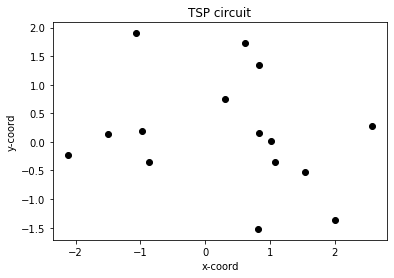

In [6]:
N = 15
locs = torch.randn(N, 2).to(device)
dmatrix = (locs.reshape(N, 1, 2) - locs.reshape(1, N, 2)).pow(2.).sum(dim=-1).sqrt().to(device)
env = FixedTSPEnv(dmatrix, locs)
env.render()
plt.show()

In [32]:
# Initialize policy/value network
actor = Actor()
critic = Critic()
critic.output_bias.data = torch.tensor(-20.0, dtype=torch.float)
actor.to(device);
critic.to(device);

In [33]:
# Initialize optimizer
lr = 1e-5
val_optimizer = optim.SGD(params=critic.parameters(), lr=lr, momentum=0.99)
actor_optimizer = optim.SGD(params=actor.parameters(), lr=lr, momentum=0.99)

In [34]:
# Log training loss, reward, etc.
with open("train.log", "w+") as fp:
    fp.write("loss,reward,q_value")

In order to encourage exploration, a random permuation of the locations is chosen with probability equal to the fraction of time left in the training loop. We run this for 20 minutes and save the critic loss, reward, and Q-value at each step:

In [35]:
# Create adjacency matrix and node features
s = env.state
A = 1/(s.dmatrix + torch.eye(N, dtype=float, device=device))
A = A / torch.max(torch.abs(A))
V = s.locs.reshape(1, -1, 2)
A = A.type(torch.float).to(device)
V = V.type(torch.float).to(device)

max_time = 20*60
tic = time.time()
episode = 0
with open("train.log", "a") as fp, tqdm.tqdm(total=max_time) as pbar:
    while time.time() - tic < max_time:
        # Take action and update state
        action = actor(A, V)
        if random.random() > (time.time() - tic)/max_time:  # Add random noise occasionally
            action = action[:,torch.randperm(N)]
        Q = critic(A, V, action)
        # Turn the ordered vector into a sequence of stops
        action = action.squeeze().argsort()
        s, r, _, _ = env.step(action, kind="re-order")
        # Update actor
        actor_optimizer.zero_grad()
        loss = -Q
        loss.backward(retain_graph=True)
        actor_optimizer.step()
        q_val = -loss.data.cpu().numpy()
        # Update critic
        val_optimizer.zero_grad()
        loss = torch.pow(r - Q, 2)
        loss.backward()
        val_optimizer.step()
        loss_val = loss.data.cpu().numpy()
        fp.write(f"\n{loss_val},{r},{q_val}")
        if episode % 100 == 99:
            pbar.n = int(time.time() - tic)
            pbar.set_description(
                f"Episode {episode+1}; "
                f"loss: {loss_val:.5f}; Q-value: {q_val:.3f}; "
                f"reward: {r:.3f}"
            )
        episode += 1

Episode 255700; loss: 0.02085; Q-value: -23.529; reward: -23.384: 100%|█████████▉| 1199/1200 [20:00&lt;00:01,  1.00s/it]


It doesn't really look like the agent learned anything useful...

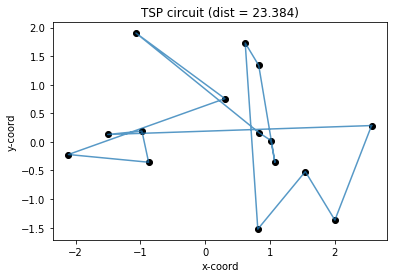

In [37]:
env.render(); plt.show()

In [38]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [39]:
train_df = pd.read_csv("train.log")
size = len(train_df)
print(f"{size} rows/episodes")
train_df.tail()

255726 rows/episodes


,loss,reward,q_value
255721,0.003595,-23.384167,-23.444126
255722,0.002623,-23.384167,-23.435383
255723,0.001792,-23.384167,-23.426495
255724,0.001111,-23.384167,-23.417505
255725,0.000590,-23.384167,-23.408455


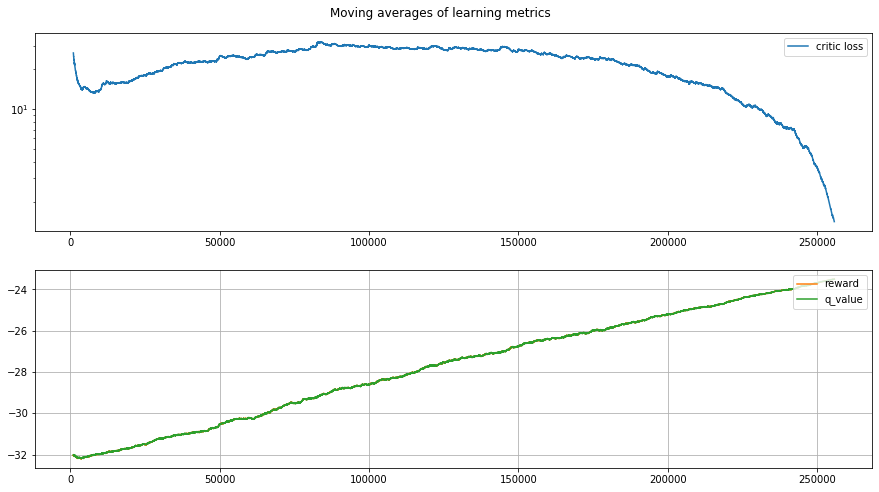

In [40]:
ma = train_df.ewm(span=len(train_df)/30).mean()
fig, axes = plt.subplots(nrows=2, figsize=(15,8))
skip = 1000

axes[0].plot(ma.iloc[skip:]['loss'], label='critic loss')
axes[0].set_yscale('log')
axes[0].legend(loc="upper right")

axes[1].plot(ma.iloc[skip:]['reward'], label='reward', color="C1")
axes[1].plot(ma.iloc[skip:]['q_value'], label='q_value', color="C2")
axes[1].grid()
axes[1].legend(loc="upper right")

fig.suptitle("Moving averages of learning metrics", x=0.5, y=0.925)
plt.show()

It seems that the critic simply learned to track the mean of the reward, rather than learning any useful correlations.

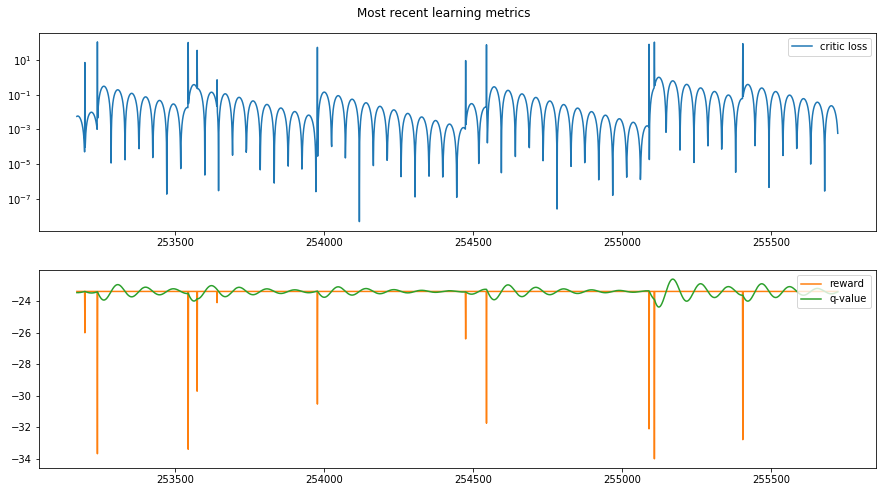

In [46]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))
# window = 10000
# df = train_df.iloc[-window:]

window_pct = (.99, 1.0)
idx = [int(round(len(train_df)*wp)) for wp in window_pct]
df = train_df.iloc[idx[0]:idx[1]]

axes[0].plot(df['loss'], label='critic loss')
axes[0].set_yscale('log')
axes[0].legend(loc="upper right")
axes[1].plot(df['reward'], label='reward', color="C1")
axes[1].plot(df['q_value'], label='q-value', color="C2")
axes[1].legend(loc="upper right")

fig.suptitle("Most recent learning metrics", x=0.5, y=0.925)
plt.show()